# Plot LRG fitsigmas chains
This jupyter notebook contains some code to make plots of the bestfits and contours for Sigma_nl's and Sigma_s for the abacus cubic LRG fits. It can be placed inside the same code as used to perform the fits, but here has been placed inside a separate Jupyter notebook to allow for real-time viewing of the plots. The only difference is that we have to read in a pickle dump of all the fitter information, which is the plotting was in the same code as the fitting we would not have to do.

In [1]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../../../Barry/")     # Change this so that it points to where you have Barry installed

from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction
from barry.utils import weighted_avg_and_cov

# Read in the fitter class to get all the info on the fit
pfn = "./plots/desi_kp4_abacus_cubic_LRG_fitsigmas/output/desi_kp4_abacus_cubic_LRG_fitsigmas.fitter.pkl"
with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)

This code segment reads in the chains, plots the bestfit model vs. data and produces a contour plot.

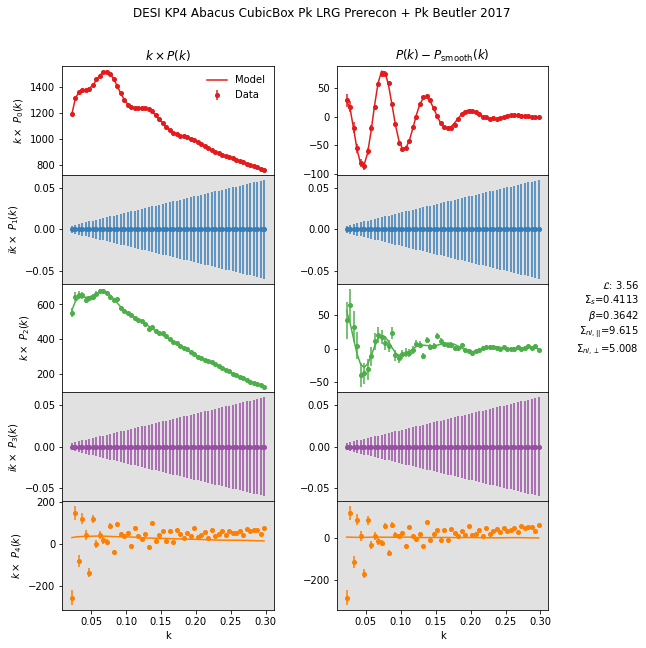

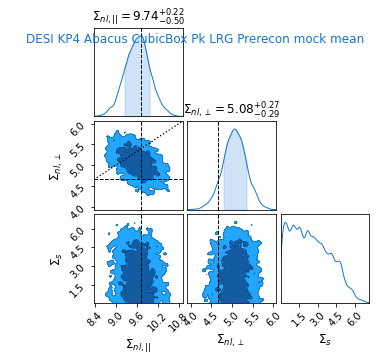

[9.620474  5.063047  2.4215164] [0.35683036 0.28322475 1.5721296 ] 118.53593219603404 95


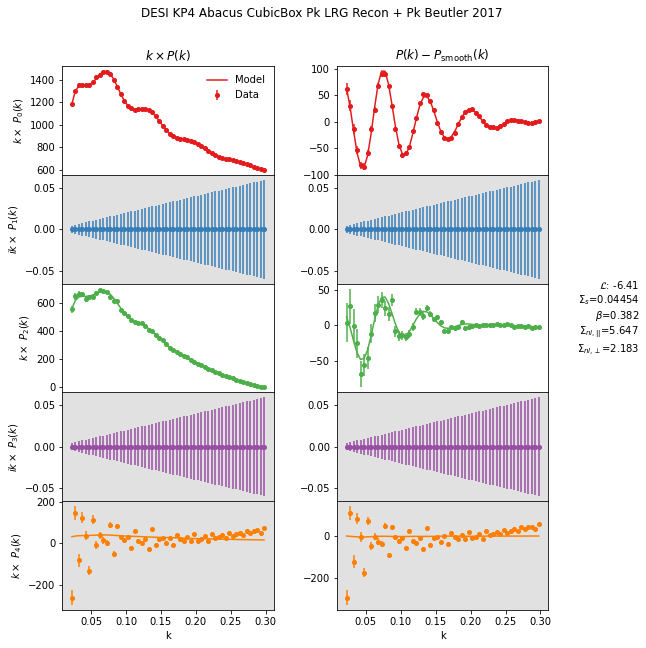

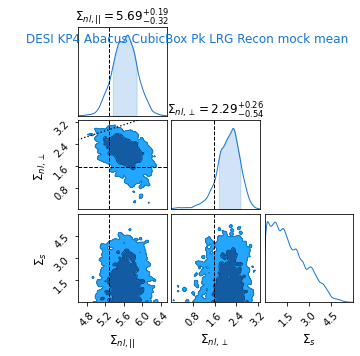

[5.6223807 2.0877116 1.6433355] [0.25606363 0.44348141 1.18134913] 133.63419926142086 95


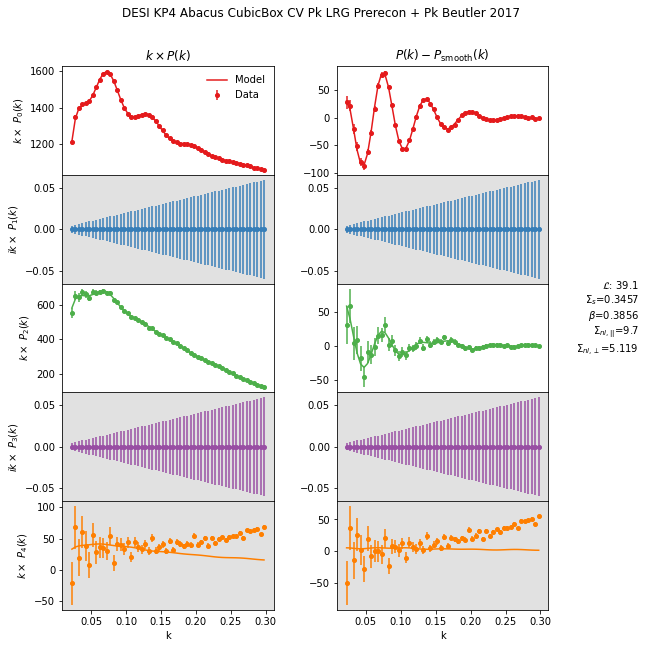

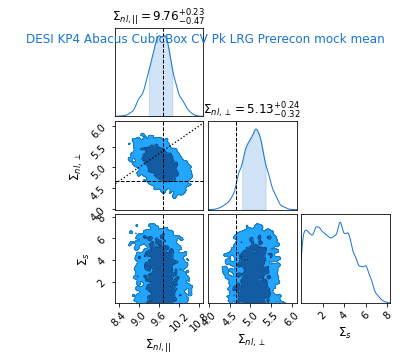

[9.648521 5.083039 2.98231 ] [0.3568092  0.28280296 1.83628979] 47.57310908948631 95


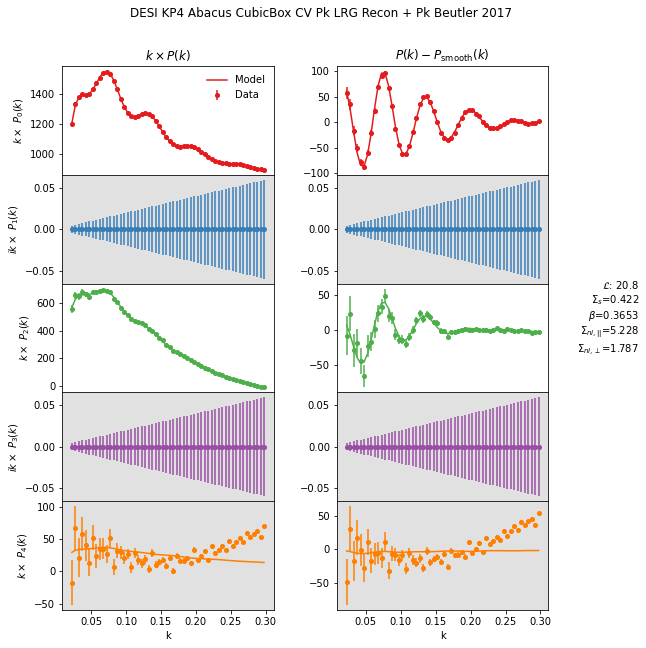

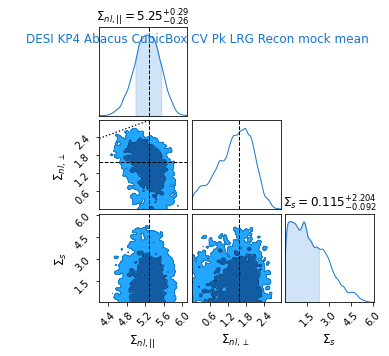

[5.245406  1.4093623 1.7300636] [0.27169389 0.58416078 1.21039312] 79.52838488213735 95


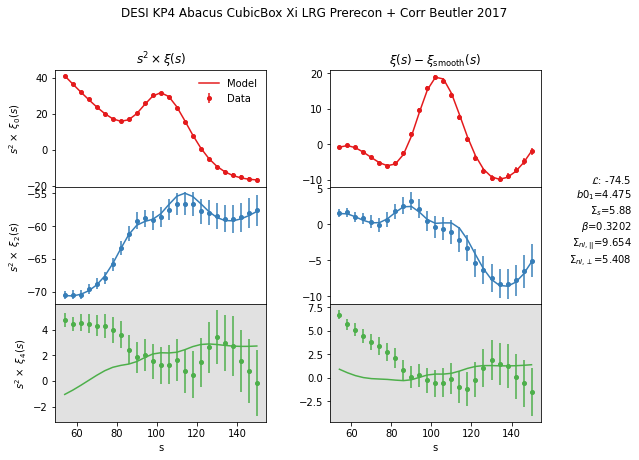

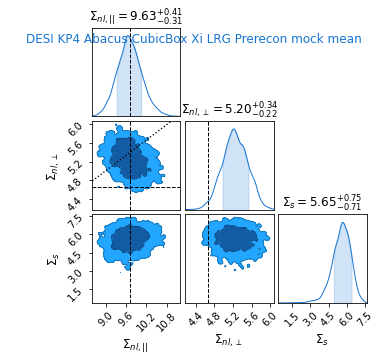

[9.710421 5.247289 5.553266] [0.36163295 0.27122007 0.78518821] 48.722273296030345 37


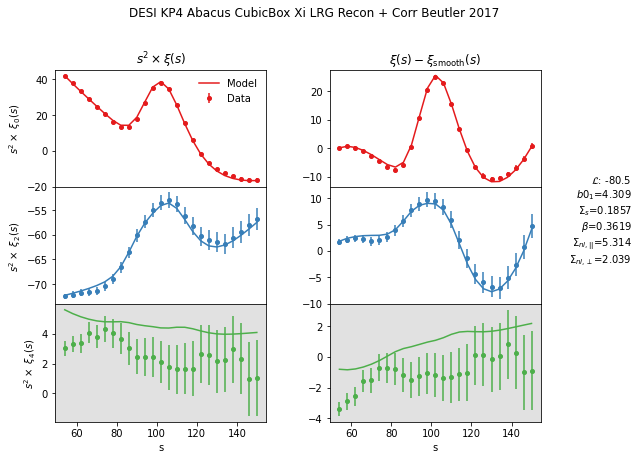

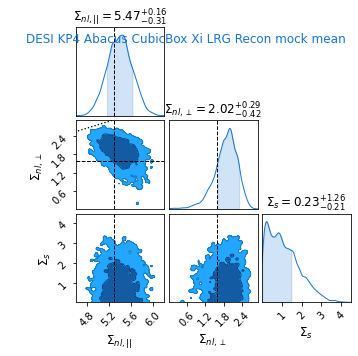

[5.3938375 1.8660793 1.108337 ] [0.22708627 0.39067154 0.79551987] 60.42231224507133 37


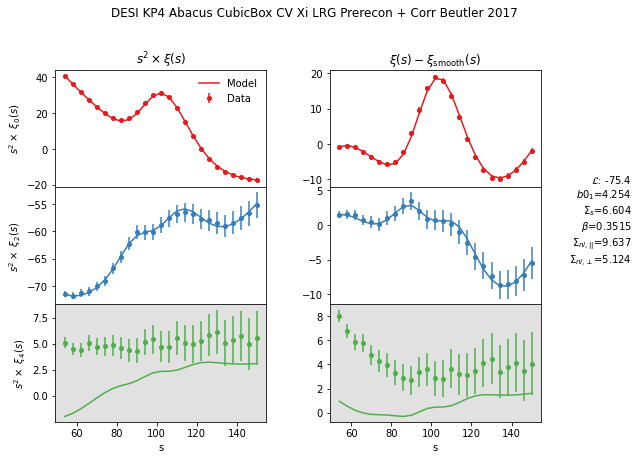

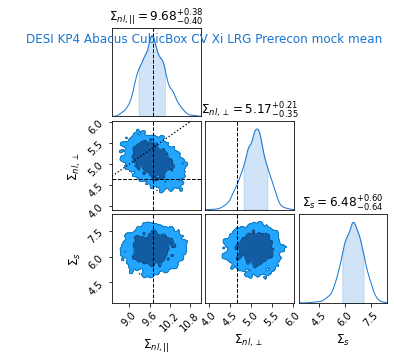

[9.705189 5.088712 6.449835] [0.38544708 0.27986525 0.62492342] 50.533525514912334 37


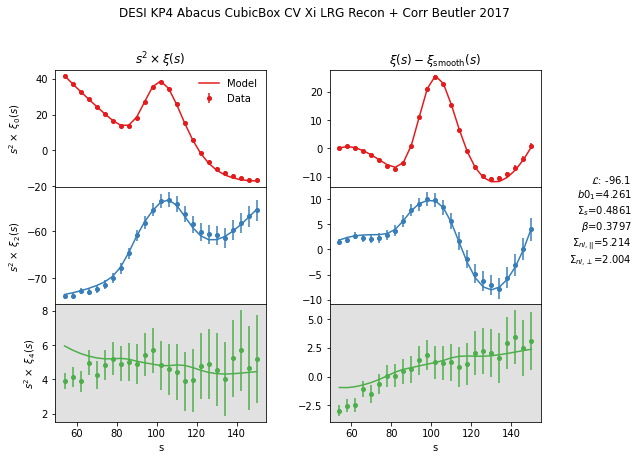

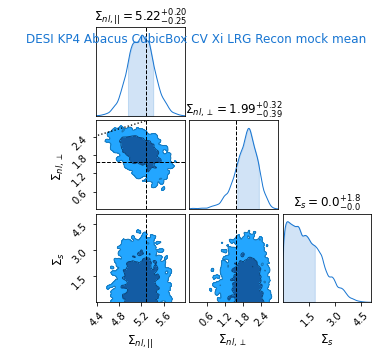

[5.1950045 1.8843665 1.378038 ] [0.22561122 0.38582479 0.9570583 ] 91.70067862995778 37


In [2]:
logging.info("Creating plots")

datanames = ["Xi", "Pk", "Pk_CV", "Xi_CV"]

# Loop over all the chains
stats = {}
output = {}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())

    # Get the MAP point and set the model up at this point
    model.set_data(data)
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=True)

    # Add the chain to Chainconsumer and plot
    c = ChainConsumer()
    extra.pop("realisation", None)
    c.add_chain(df, weights=weight, **extra, plot_contour=True, plot_point=False, show_as_1d_prior=False)
    mean, cov = weighted_avg_and_cov(
        df[["$\\Sigma_{nl,||}$", "$\\Sigma_{nl,\\perp}$", "$\\Sigma_s$"]],
        weight,
        axis=0,
    )
    if "Pre" in extra["name"]:
        truth = {"$\\Sigma_{nl,||}$": 9.71, "$\\Sigma_{nl,\\perp}$": 4.66, "$\\Sigma_s$": None}
    else:
        truth = {"$\\Sigma_{nl,||}$": 5.29, "$\\Sigma_{nl,\\perp}$": 1.57, "$\\Sigma_s$": None}
    fig = c.plotter.plot(
        parameters=["$\\Sigma_{nl,||}$", "$\\Sigma_{nl,\\perp}$", "$\\Sigma_s$"],
        legend=True,
        truth=truth,
    )
    xvals = np.linspace(0.0, 20.0, 100)
    fig.get_axes()[3].plot(xvals, xvals / (1.0 + 0.8), color="k", linestyle=":", linewidth=1.3)
    plt.show()

    print(mean, np.sqrt(np.diag(cov)), new_chi_squared, dof)